In [2]:
#Library for edit dataset
import pandas as pd
import numpy as np
import datetime as dp

#Library for visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import folium 
from folium.plugins import StripePattern
import branca.colormap
from collections import defaultdict
from folium.plugins import HeatMap

#Calculate distance on latitude and longitude
from math import radians, cos, sin, asin, sqrt

#Library to find correlation in categorical data
from pandas import factorize

# Modeling
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.utils import resample
warnings.filterwarnings('ignore')


# **Introduction**

**This project covers Customer Segmentation Using Domain Knowledge,KMeans and DBScan Clustering based on RFM (Recency, Frequency, Monetary)Analytics**

## **Background**

E-commerce is a business model that allows companies or individuals to buy or sell goods via the internet. E-commerce customers have unimaginable variety personalities, a potential market is usually not characterized singularly nor easily. It becomes important to know your target customer base in order to make sure your communications are both effective (attractive, action-promoting) and appropriate (non-offensive, timely, and relevant).[1] RFM analysis is a customer behavior segmentation technique. Based on customers' historical transactions, RFM analysis focuses on 3 main aspects of customers' transactions: recency, frequency and purchase amount. Understanding these behaviors will allow businesses to cluster different customers into groups. [2]



## **Problem Statement**
The main goal of this project is to help meet the expectations of the algorithm to be created for the grouping of each user segment through the following objectives:

◉ Group customers based on their behavior so that they are divided into several segments based on RFM Analytics.

◉ Find out the defining characteristics in each customer segment

# **Data Understanding**

## **Dataset Public E-Commerce Brasil by Olist**

The dataset has information of 100k orders from 2016 to 2018 made in several markets in Brazil. This is real commercial data, it has been anonymized.
This dataset is generously provided by Olist, the largest department store on the Brazilian market. Olist connects small businesses from all over Brazil to the channel without any hassle and with one contract. The merchant can sell their products through the Olist Store and have them shipped directly to the customer using the Olist logistics partner. Once the customer purchases the product from the Olist Store, the seller will be notified to fulfill that order. Once the customer receives the product, or the estimated delivery date is due, the customer gets a satisfaction survey via email where he or she can provide a note for the purchase experience and some comments.

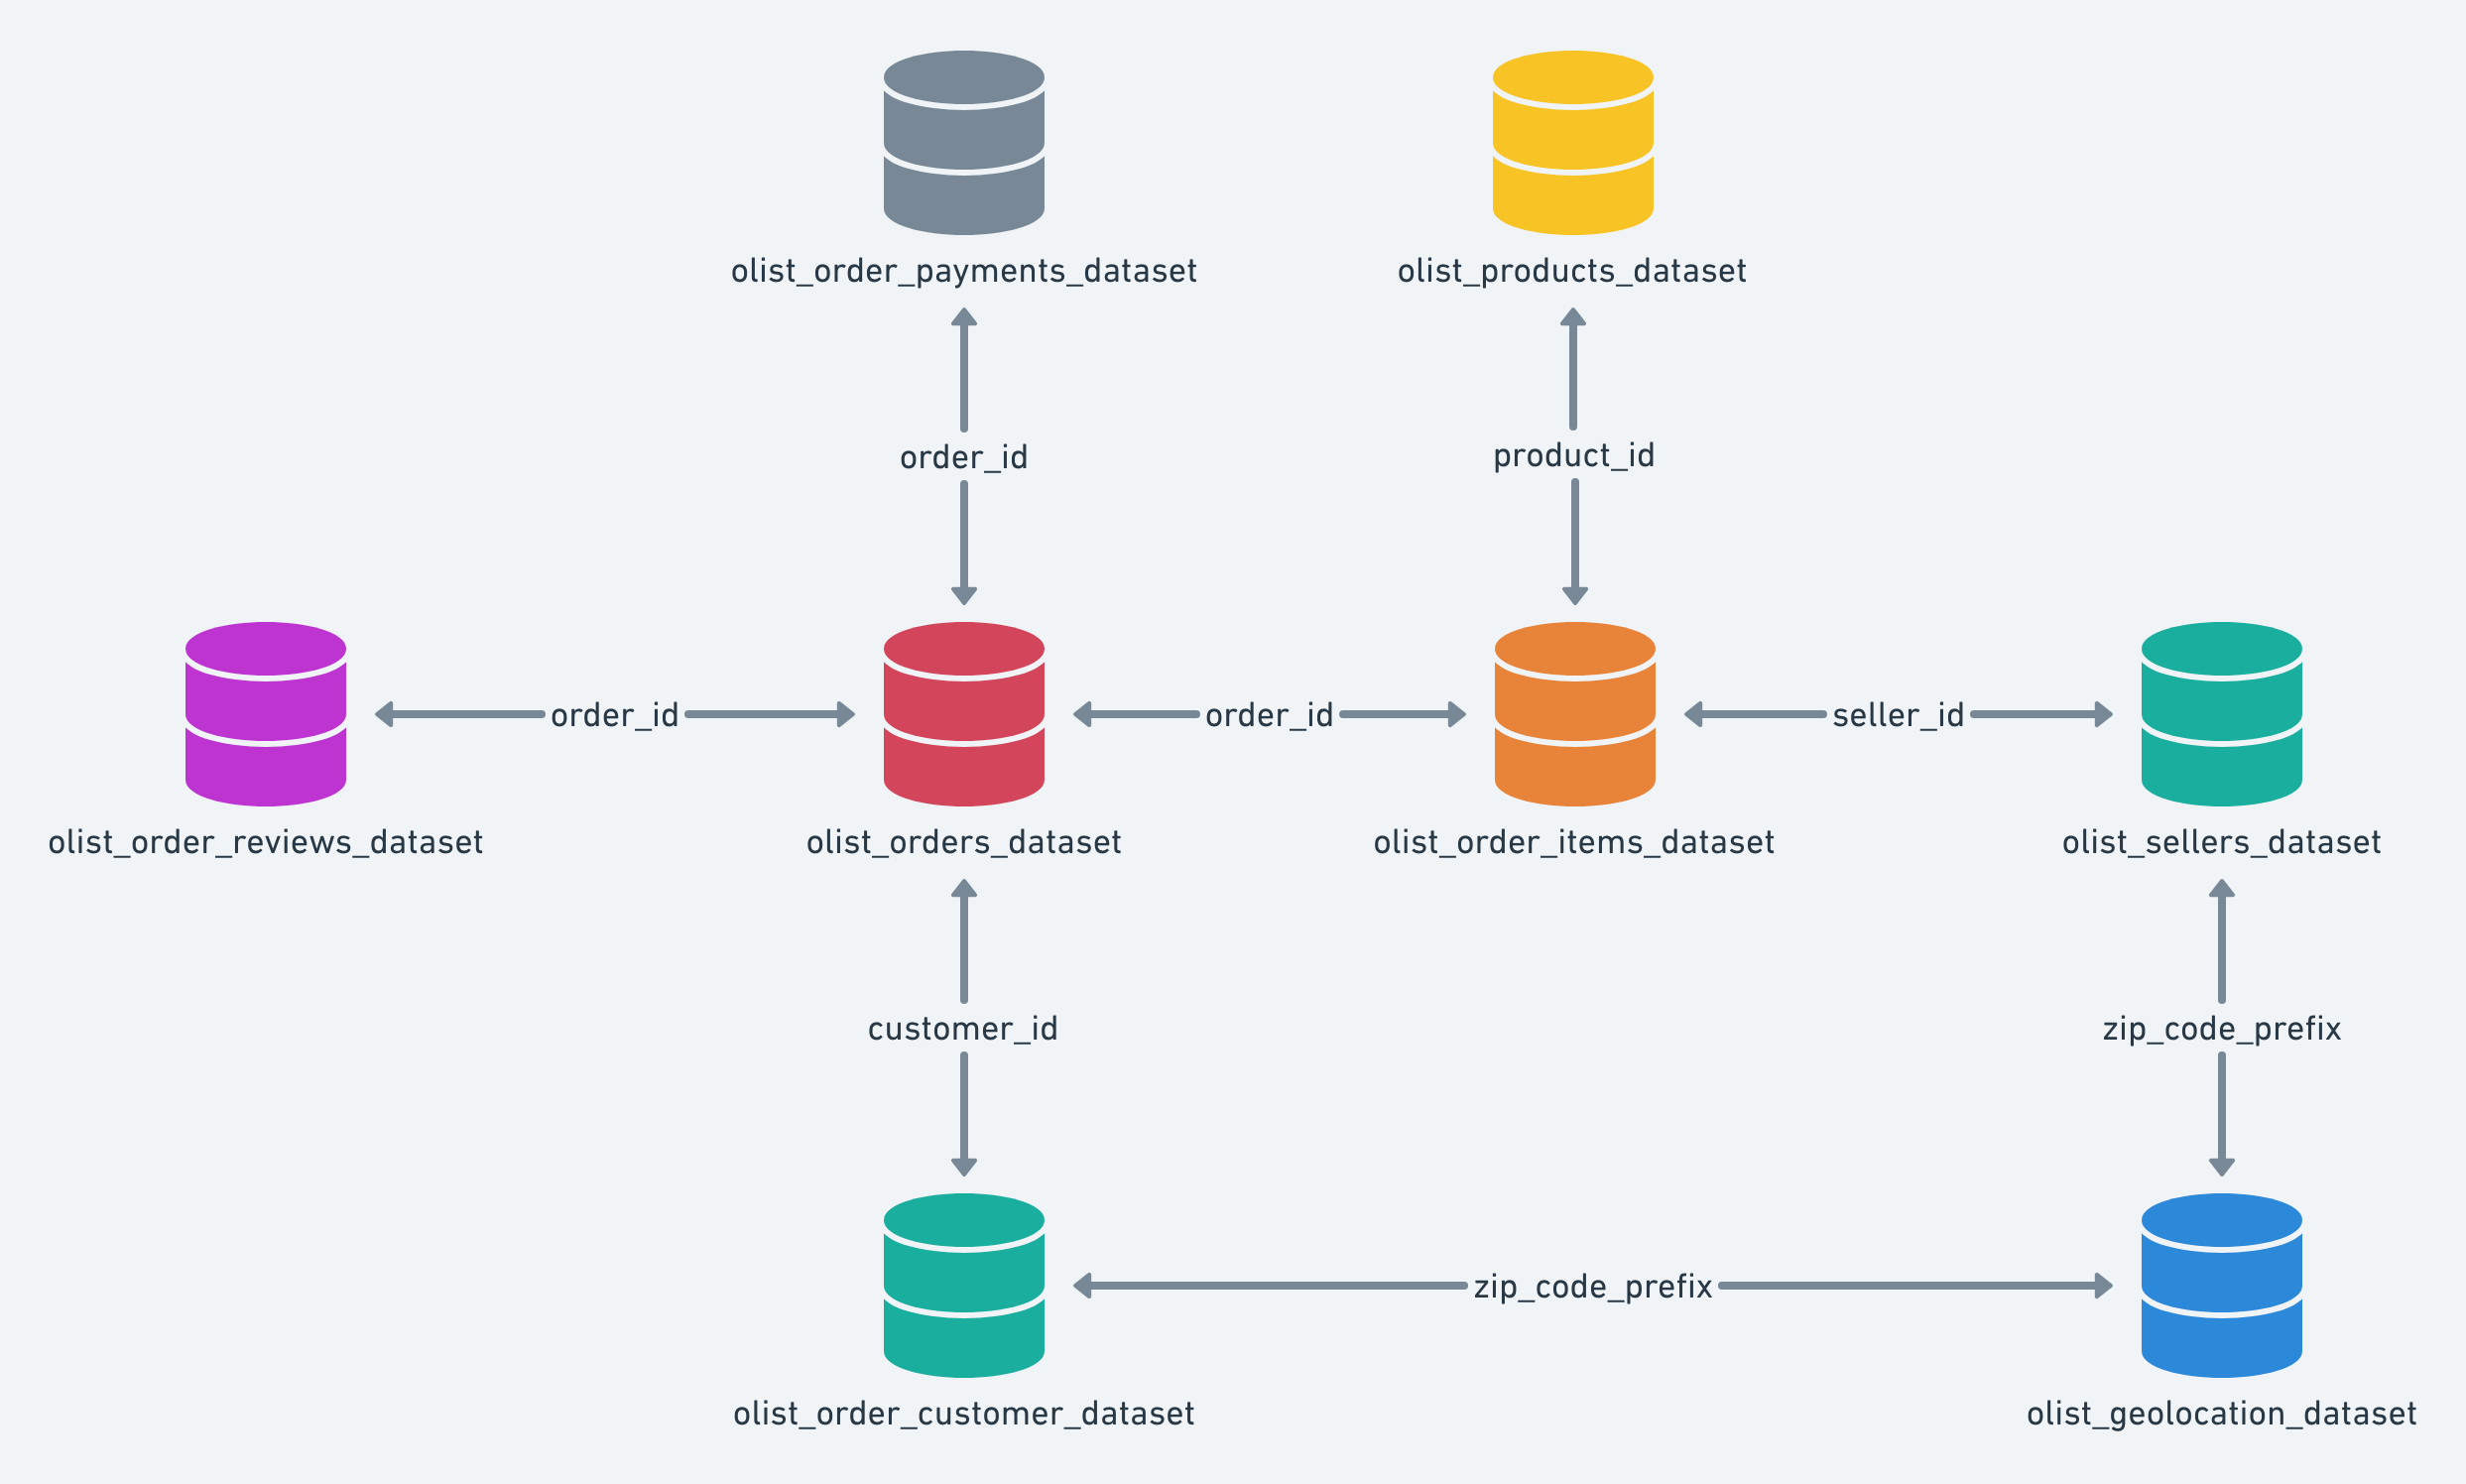

| Columns Name | Data Type, Length | Description | Present |
| -- | -- | -- | -- |
| customer_id | object | Key to the orders dataset. Each order has a unique customer_id.| Unique customer id to merge with orders dataset |
| customer_unique_id | object | unique identifier of a customer.| represent customer unique id
| customer_zip_code_prefix | int64 | first five digits of customer zip code| represent first five zip code of geolocation customer
| customer_city  |  object |customer city name| a customer city name in brazzil
| customer_state |  object |customer state| represent 2 letters of name customer sate
| geolocation_zip_code_prefix | int64 |first 5 digits of zip code| represent first five zip code of geolocation city and state
| geolocation_lat | float64 |Geolocation latitude| represent of the angular distance of a place north or south of the earth's equator, or of a celestial object north or south of the celestial equator, expressed in degrees.
| geolocation_lng | float64 |Geolocation longitude| the angular distance of a place east or west of the meridian at Greenwich, England, or west of the standard meridian of a celestial object, expressed in degrees.
| geolocation_city |  object |city name| represent of geolocation city name
| geolocation_state |  object |state| represent 2 letter of state where the geolocation is 
| order_id  |  object |order unique identifier| An unique id where every transaction have order id
| order_item_id | int64 |sequential number identifying number of items included in the same order.| A serial number for an unique identifier assigned  sequentially to an item, to uniquely identify it
| product_id  |  object |product unique identifier| A serial number for a unique identifier assigned  to an product, to uniquely identify it
| seller_id | object  |seller unique identifier| A serial number for a unique identifier assigned  to an seller, to uniquely identify it
| shipping_limit_date| object  |Shows the seller shipping limit date for handling the order over to the logistic partner.| the estimated delivery date is when a customer can reasonably expect the order to arrive.
| price | float64 |item price| the retail price of each item of consumer goods.
| freight_value | float64 |item freight value item (if an order has more than one item the freight value is splitted between)|  a price at which a certain cargo is delivered from one point to another
| payment_sequential | int64 |a customer may pay an order with more than one payment method. If he does so, a sequence will be| a sequential pay structure, principal payments are typically allocated to the securities in order of seniority.
| payment_type |  object |method of payment chosen by the customer.| A various of type payment for customer to pay a transaction
| payment_installments | int64 |number of installments chosen by the customer.| Instalment payments refer to a customer paying a bill in small portions throughout a fixed period of time
| payment_value  | float64 | transaction value.| A total of amount money customer need to pay to succesfull transaction

In [3]:
# Change the product name to english
products = pd.read_csv("olist_products_dataset.csv")
prod_cat_name_tr = pd.read_csv("product_category_name_translation.csv")
products = products.merge(prod_cat_name_tr, on='product_category_name', how='left')
products.drop ('product_category_name', axis=1, inplace=True)

In [4]:
#load all the tables
o_items = pd.read_csv("olist_order_items_dataset.csv")
orders = pd.read_csv("olist_orders_dataset.csv")
o_reviews = pd.read_csv("olist_order_reviews_dataset.csv")
geoloc = pd.read_csv("olist_geolocation_dataset.csv")
sellers = pd.read_csv("olist_sellers_dataset.csv")
o_payments = pd.read_csv("olist_order_payments_dataset.csv")
customers = pd.read_csv("olist_customers_dataset.csv")

In [5]:
# Join the needed table
df = orders.merge(o_items, on='order_id', how='left')
df = df.merge(o_payments, on='order_id', how='outer', validate='m:m')
df = df.merge(products, on='product_id', how='outer')
df = df.merge(customers, on='customer_id', how='outer')
df = df.merge(sellers, on='seller_id', how='outer')

In [6]:
# remove columns yang tidak butuh
df = df.drop(axis=1,
columns=['product_name_lenght',
'product_description_lenght',
'product_photos_qty',
'product_weight_g',
'product_length_cm',
'product_height_cm',
'product_width_cm',
'order_delivered_carrier_date',
'order_delivered_customer_date',
'order_estimated_delivery_date'
,'shipping_limit_date','order_approved_at'])

In [7]:
# Change to Datetime
df['order_purchase_date']=pd.to_datetime(df['order_purchase_timestamp'])

In [8]:
df['order_purchase_date'] = pd.to_datetime(df['order_purchase_timestamp'])
df['order_purchase_date'] = df['order_purchase_date'].dt.strftime('%Y-%m-%d-%H')
df['order_purchase_date'] = pd.to_datetime(df['order_purchase_date'])

In [9]:
df['year'] = df['order_purchase_date'].dt.year
df['month'] = df['order_purchase_date'].dt.strftime('%b')
df['day'] = df['order_purchase_date'].dt.day

# **Preprocessing**

### **Drop Misspelling and Anomali Data**


**This dataset has some misspelling in seller_city column, there are 04482255, vendas@creditparts.com.br, rio de janeiro / rio de janeiro, sao paulo / sao paulo, rio de janeiro \\rio de janeiro, ribeirao preto / sao paulo, sp, carapicuiba / sao paulo, mogi das cruzes / sp, sp / sp, auriflama/sp, pinhais/pr, cariacica / es, jacarei / sao paulo, sao sebastiao da grama/sp, maua/sao paulo,  and lages - sc.**

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118434 entries, 0 to 118433
Data columns (total 25 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       118434 non-null  object        
 1   customer_id                    118434 non-null  object        
 2   order_status                   118434 non-null  object        
 3   order_purchase_timestamp       118434 non-null  object        
 4   order_item_id                  117604 non-null  float64       
 5   product_id                     117604 non-null  object        
 6   seller_id                      117604 non-null  object        
 7   price                          117604 non-null  float64       
 8   freight_value                  117604 non-null  float64       
 9   payment_sequential             118431 non-null  float64       
 10  payment_type                   118431 non-null  object        
 11  

In [11]:
df = df[(df['payment_type'] != 'not_defined') | (df['seller_city'] != '04482255') | (df['seller_city'] != 'vendas@creditparts.com.br') |
        (df['seller_city'] != 'rio de janeiro / rio de janeiro') | (df['seller_city'] != 'sao paulo / sao paulo') | (df['seller_city'] != 'rio de janeiro \\rio de janeiro') 
        | (df['seller_city'] != 'ribeirao preto / sao paulo' ) | (df['seller_city'] != 'sp') | (df['seller_city'] != 'carapicuiba / sao paulo') | (df['seller_city'] != 'mogi das cruzes / sp')
        | (df['seller_city'] != 'sp / sp') | (df['seller_city'] != 'auriflama/sp') | (df['seller_city'] != 'pinhais/pr') | (df['seller_city'] != 'cariacica / es') | (df['seller_city'] != 'jacarei / sao paulo')
        | (df['seller_city'] != 'sao sebastiao da grama/sp') | (df['seller_city'] != 'maua/sao paulo') | (df['seller_city'] != ' ') | (df['seller_city'] != 'lages - sc') 
        | (df['year'] != 2016) | (df['order_purchase_timestamp'] != '2018-09-03 09:06:57')]

### **Drop mising value**

In [12]:
df.dropna(axis=0,inplace=True,subset=['product_id', 'seller_id', 'payment_sequential','payment_type', 'payment_installments', 'payment_value'])

In [13]:
df.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_item_id                       0
product_id                          0
seller_id                           0
price                               0
freight_value                       0
payment_sequential                  0
payment_type                        0
payment_installments                0
payment_value                       0
product_category_name_english    1723
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
seller_zip_code_prefix              0
seller_city                         0
seller_state                        0
order_purchase_date                 0
year                                0
month                               0
day                                 0
dtype: int64

In [14]:
df['product_category_name_english'].fillna('Missing', inplace = True)

In [15]:
df.isna().sum()

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_item_id                    0
product_id                       0
seller_id                        0
price                            0
freight_value                    0
payment_sequential               0
payment_type                     0
payment_installments             0
payment_value                    0
product_category_name_english    0
customer_unique_id               0
customer_zip_code_prefix         0
customer_city                    0
customer_state                   0
seller_zip_code_prefix           0
seller_city                      0
seller_state                     0
order_purchase_date              0
year                             0
month                            0
day                              0
dtype: int64

In [16]:
#Combine dataframe with geolocation coordinates.

df.rename(columns={'customer_zip_code_prefix': 'zip_code_prefix'}, inplace = True)

### **Making Data Frame for RFM Analytics & Models**

**At our system each order is assigned to a unique customerid. This means that the same customer will get different ids for different orders. The purpose of having a customerunique_id on the dataset is to allow you to identify customers that made repurchases at the store**

### Recency

How often buyers make purchases based on the time gap between purchases.

In [17]:
recency = df[['customer_unique_id', 'order_purchase_date']].copy()

In [18]:
#calculating recency value
recency = recency.groupby('customer_unique_id')['order_purchase_date'].max().reset_index()
recency.columns = ['customer_unique_id', 'last_purchase_timestamp']

recency['purchase_int'] = (recency['last_purchase_timestamp'].max() - recency['last_purchase_timestamp']).dt.days
recency.drop(columns='last_purchase_timestamp', inplace=True)

In [19]:
#finding best cluster spliter based on percentile
recency_cluster=list(recency['purchase_int'].quantile([0,0.25,0.50,0.75,1]))

In [105]:
#segment each value to cluster
recency_lst = recency['purchase_int']
recency_cluster = []

for i in recency_lst:
    if i < 165:
        cluster = 3
        recency_cluster.append(cluster)
    elif i < 270:
        cluster = 2
        recency_cluster.append(cluster)
    elif i < 399:
        cluster = 1
        recency_cluster.append(cluster)
    else:
        cluster = 0
        recency_cluster.append(cluster)


In [106]:
#adding cluster column
recency['recency_cluster'] = recency_cluster
recency

,customer_unique_id,purchase_int,recency_cluster
0,0000366f3b9a7992bf8c76cfdf3221e2,115,3
1,0000b849f77a49e4a4ce2b2a4ca5be3f,118,3
2,0000f46a3911fa3c0805444483337064,541,0
3,0000f6ccb0745a6a4b88665a16c9f078,325,1
4,0004aac84e0df4da2b147fca70cf8255,292,1
...,...,...,...
95414,fffcf5a5ff07b0908bd4e2dbc735a684,451,0
95415,fffea47cd6d3cc0a88bd621562a9d061,266,2
95416,ffff371b4d645b6ecea244b27531430a,572,0
95417,ffff5962728ec6157033ef9805bacc48,123,3


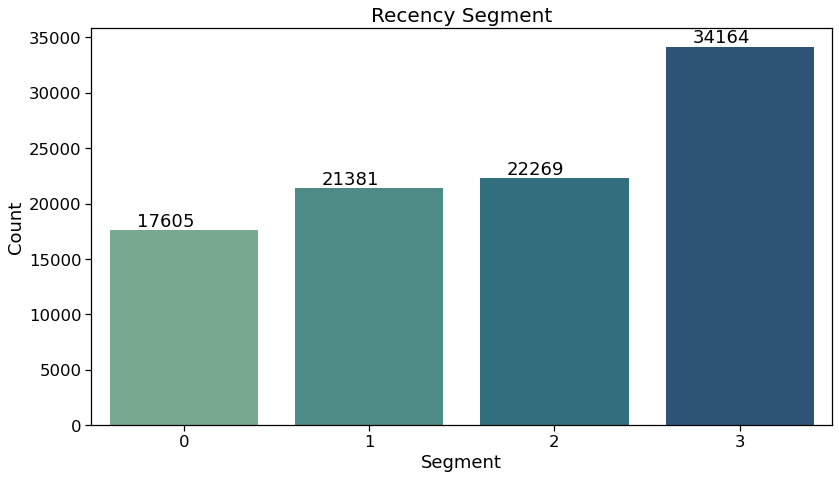

In [107]:
plt.figure(figsize=(12, 7))
recency_cat = recency['recency_cluster'].value_counts()
pal = sns.color_palette('crest', len(recency_cat))
graph =sns.barplot(x=recency_cat.index, y=recency_cat.values, palette=pal) 
for p in graph.patches:
        graph.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()),
                    ha='center', va='bottom',
                    color= 'black')     
plt.title('Recency Segment', size=20)
plt.ylabel('Count')
plt.xlabel('Segment')
plt.tight_layout()
plt.show()

### Frequency


How often a customer makes a purchase.

In [23]:
frequency =pd.DataFrame(df.groupby('customer_unique_id')['order_id'].count().reset_index())
frequency


,customer_unique_id,order_id
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1
...,...,...
95414,fffcf5a5ff07b0908bd4e2dbc735a684,2
95415,fffea47cd6d3cc0a88bd621562a9d061,1
95416,ffff371b4d645b6ecea244b27531430a,1
95417,ffff5962728ec6157033ef9805bacc48,1


Text(0.5, 1.0, 'Distribution of the number of orders per customer')

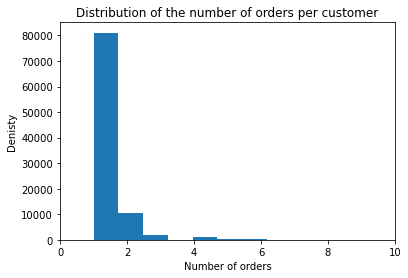

In [24]:
#look for distribution
frequency['order_id'].plot.hist(bins=100)
plt.xlim(0,10)
plt.xlabel('Number of orders')
plt.ylabel('Denisty')
plt.title('Distribution of the number of orders per customer')

In [25]:
#find best k using kmeans
inertia = {}

for k in range(1,10):
    km = KMeans(n_clusters=k)
    km = km.fit(frequency[['order_id']])
    inertia[k] = km.inertia_

Text(0, 0.5, 'Inertia')

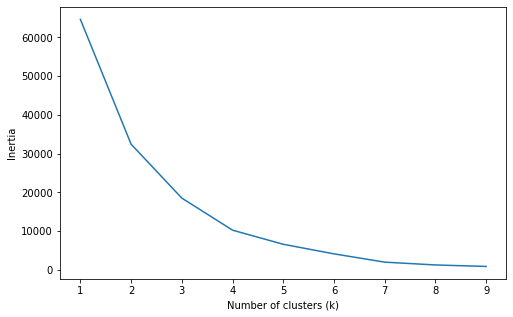

In [26]:
plt.figure(figsize=(8,5))
plt.plot(list(inertia.keys()), list(inertia.values()))
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')

In [27]:
#applying kmeans
km = KMeans(n_clusters=4, random_state=42)
km.fit(frequency[['order_id']])
frequency['cluster'] = km.labels_

In [28]:
#checking cluster distribution
frequency['cluster'].value_counts()


0    81088
1    12593
2     1635
3      103
Name: cluster, dtype: int64

In [29]:
frequency.groupby('cluster')['order_id'].describe().sort_values(by='mean')

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,81088.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
1,12593.0,2.154133,0.361091,2.0,2.0,2.0,2.0,3.0
2,1635.0,4.825076,1.135812,4.0,4.0,4.0,6.0,9.0
3,103.0,14.533981,7.972767,10.0,11.0,12.0,15.0,75.0


In [30]:
#reassign cluster grouping for better intepretation
frequency_cluster = frequency.groupby('cluster')['order_id'].mean().reset_index()
frequency_cluster = frequency_cluster.sort_values(by='order_id').reset_index(drop=True)
frequency_cluster['index'] = np.arange(0,4)
frequency_cluster.set_index('cluster', inplace=True)
cluster_dict = frequency_cluster['index'].to_dict()
frequency['cluster'].replace(cluster_dict, inplace=True)

In [31]:
frequency.groupby('cluster')['order_id'].describe().sort_values(by='mean')

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,81088.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
1,12593.0,2.154133,0.361091,2.0,2.0,2.0,2.0,3.0
2,1635.0,4.825076,1.135812,4.0,4.0,4.0,6.0,9.0
3,103.0,14.533981,7.972767,10.0,11.0,12.0,15.0,75.0


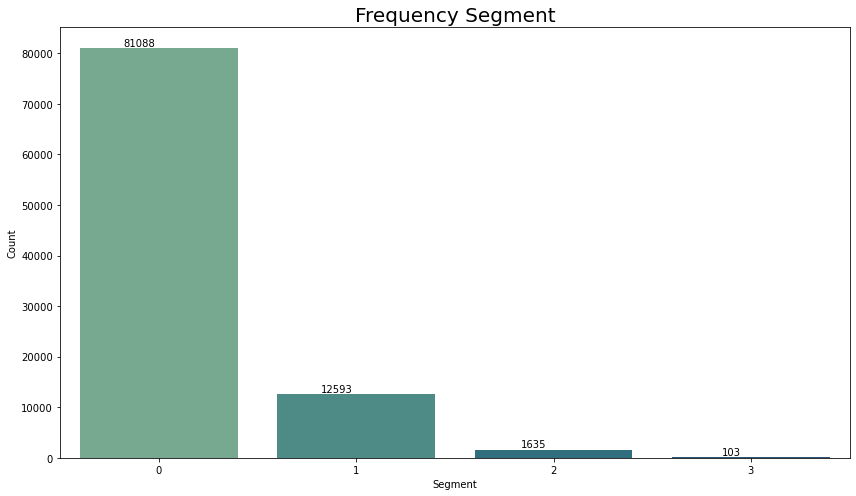

In [32]:
plt.figure(figsize=(12, 7))
frequency_cat = frequency['cluster'].value_counts()
pal = sns.color_palette('crest', len(frequency_cat))
graph =sns.barplot(x=frequency_cat.index, y=frequency_cat.values, palette=pal) 
for p in graph.patches:
        graph.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()),
                    ha='center', va='bottom',
                    color= 'black')     
plt.title('Frequency Segment', size=20)
plt.ylabel('Count')
plt.xlabel('Segment')
plt.tight_layout()
plt.show()

### Monetary

How much money a customer spends on purchases.

In [33]:
monetary =pd.DataFrame(df.groupby('customer_unique_id')['payment_value'].sum().reset_index())
monetary


,customer_unique_id,payment_value
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19
2,0000f46a3911fa3c0805444483337064,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,43.62
4,0004aac84e0df4da2b147fca70cf8255,196.89
...,...,...
95414,fffcf5a5ff07b0908bd4e2dbc735a684,4134.84
95415,fffea47cd6d3cc0a88bd621562a9d061,84.58
95416,ffff371b4d645b6ecea244b27531430a,112.46
95417,ffff5962728ec6157033ef9805bacc48,133.69


In [34]:
#checking splitter based on percentile
monetary_cluster=list(monetary['payment_value'].quantile([0,0.25,0.50,0.75,1]))

In [35]:
monetary_cluster

[9.59, 63.91, 113.15, 202.54500000000002, 109312.64]

In [36]:
#dividing value to a cluster
monetary_lst = monetary['payment_value']
monetary_cluster = []

for i in monetary_lst:
    if i < 61.44:
        cluster = 0
        monetary_cluster.append(cluster)
    elif i < 106.26:
        cluster = 1
        monetary_cluster.append(cluster)
    elif i < 183.79:
        cluster = 2
        monetary_cluster.append(cluster)
    else:
        cluster = 3
        monetary_cluster.append(cluster)


In [37]:
monetary['monetary_cluster'] = monetary_cluster

In [38]:
monetary

,customer_unique_id,payment_value,monetary_cluster
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90,2
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19,0
2,0000f46a3911fa3c0805444483337064,86.22,1
3,0000f6ccb0745a6a4b88665a16c9f078,43.62,0
4,0004aac84e0df4da2b147fca70cf8255,196.89,3
...,...,...,...
95414,fffcf5a5ff07b0908bd4e2dbc735a684,4134.84,3
95415,fffea47cd6d3cc0a88bd621562a9d061,84.58,1
95416,ffff371b4d645b6ecea244b27531430a,112.46,2
95417,ffff5962728ec6157033ef9805bacc48,133.69,2


In [39]:
monetary.groupby('monetary_cluster')['payment_value'].describe().sort_values(by='mean')

,count,mean,std,min,25%,50%,75%,max
monetary_cluster,,,,,,,,
0,22243.0,42.527571,11.119101,9.59,34.05,43.00,52.010,61.43
1,22796.0,81.753941,13.071577,61.44,70.05,80.67,92.870,106.25
2,23123.0,140.351558,21.926573,106.26,120.45,138.41,158.755,183.78
3,27257.0,522.918224,1141.287567,183.79,225.97,312.74,518.240,109312.64


In [40]:
#checking cluster distribution
monetary['monetary_cluster'].value_counts()

3    27257
2    23123
1    22796
0    22243
Name: monetary_cluster, dtype: int64

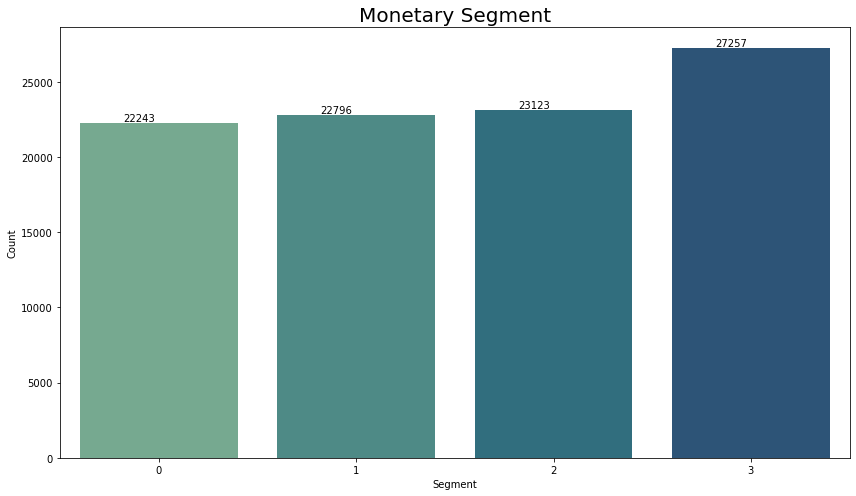

In [41]:
plt.figure(figsize=(12, 7))
monetary_cat = monetary['monetary_cluster'].value_counts()
pal = sns.color_palette('crest', len(monetary_cat))
graph =sns.barplot(x=monetary_cat.index, y=monetary_cat.values, palette=pal) 
for p in graph.patches:
        graph.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()),
                    ha='center', va='bottom',
                    color= 'black')     
plt.title('Monetary Segment', size=20)
plt.ylabel('Count')
plt.xlabel('Segment')
plt.tight_layout()
plt.show()

In [42]:
# Merging each column
overall = recency.merge(frequency, on='customer_unique_id')
overall = overall.merge(monetary, on='customer_unique_id')

# Rename columns for better intepretation
overall.rename(columns={'cluster':'frequency_cluster', 'purchase_int':'recency', 'num_transaction':'frequency','payment_value':'monetary','order_id':'frequency'}, inplace=True)

# Adding overall column by sum all cluster
overall['overall_score'] = overall['recency_cluster']+overall['frequency_cluster']+overall['monetary_cluster']

overall

,customer_unique_id,recency,recency_cluster,frequency,frequency_cluster,monetary,monetary_cluster,overall_score
0,0000366f3b9a7992bf8c76cfdf3221e2,115,0,1,0,141.90,2,2
1,0000b849f77a49e4a4ce2b2a4ca5be3f,118,0,1,0,27.19,0,0
2,0000f46a3911fa3c0805444483337064,541,3,1,0,86.22,1,4
3,0000f6ccb0745a6a4b88665a16c9f078,325,2,1,0,43.62,0,2
4,0004aac84e0df4da2b147fca70cf8255,292,2,1,0,196.89,3,5
...,...,...,...,...,...,...,...,...
95414,fffcf5a5ff07b0908bd4e2dbc735a684,451,3,2,1,4134.84,3,7
95415,fffea47cd6d3cc0a88bd621562a9d061,266,1,1,0,84.58,1,2
95416,ffff371b4d645b6ecea244b27531430a,572,3,1,0,112.46,2,5
95417,ffff5962728ec6157033ef9805bacc48,123,0,1,0,133.69,2,2


## **Methodology (Machine Learning)**

#### Without modeling, we can group several overall_score into segments. Here we decided that we will have 4 main segments. Loyal, Valuable, Regular, Passive. We will group 0-1 score as regular, 2-4 as passive, 5-7 as Valuable, 8-9 as Loyal.

**Passive is when frequency, monetary values are the lowest, recency are highest. Regular is when transaction value is increasing but still low and monetary value is the second lowest after passive. Valuable is when a transaction and it's value are the second highest, frequency value is high. Loyal is frequency,and monetary values are the highest and recency is lowest.**

In [108]:
#assign customer segmentation based on overall score
segment_lst = overall['overall_score']
segment_cluster = []

for i in segment_lst:
    if i <= 1:
        cluster = 'regular'
        segment_cluster.append(cluster)
    elif i <= 4:
        cluster = 'passive'
        segment_cluster.append(cluster)
    elif i <= 1:
        cluster = 'regular'
        segment_cluster.append(cluster)
    elif i <= 7:
        cluster = 'valuable'
        segment_cluster.append(cluster)
    else:
        cluster = 'loyal'
        segment_cluster.append(cluster)

In [109]:
overall['customer_segment'] = segment_cluster

In [110]:
overall['customer_segment'].value_counts()

passive     55967
regular     20435
valuable    18726
loyal         291
Name: customer_segment, dtype: int64

In [111]:
overall

,customer_unique_id,recency,recency_cluster,frequency,frequency_cluster,monetary,monetary_cluster,overall_score,customer_segment
0,0000366f3b9a7992bf8c76cfdf3221e2,115,0,1,0,141.90,2,2,passive
1,0000b849f77a49e4a4ce2b2a4ca5be3f,118,0,1,0,27.19,0,0,regular
2,0000f46a3911fa3c0805444483337064,541,3,1,0,86.22,1,4,passive
3,0000f6ccb0745a6a4b88665a16c9f078,325,2,1,0,43.62,0,2,passive
4,0004aac84e0df4da2b147fca70cf8255,292,2,1,0,196.89,3,5,valuable
...,...,...,...,...,...,...,...,...,...
95414,fffcf5a5ff07b0908bd4e2dbc735a684,451,3,2,1,4134.84,3,7,valuable
95415,fffea47cd6d3cc0a88bd621562a9d061,266,1,1,0,84.58,1,2,passive
95416,ffff371b4d645b6ecea244b27531430a,572,3,1,0,112.46,2,5,valuable
95417,ffff5962728ec6157033ef9805bacc48,123,0,1,0,133.69,2,2,passive


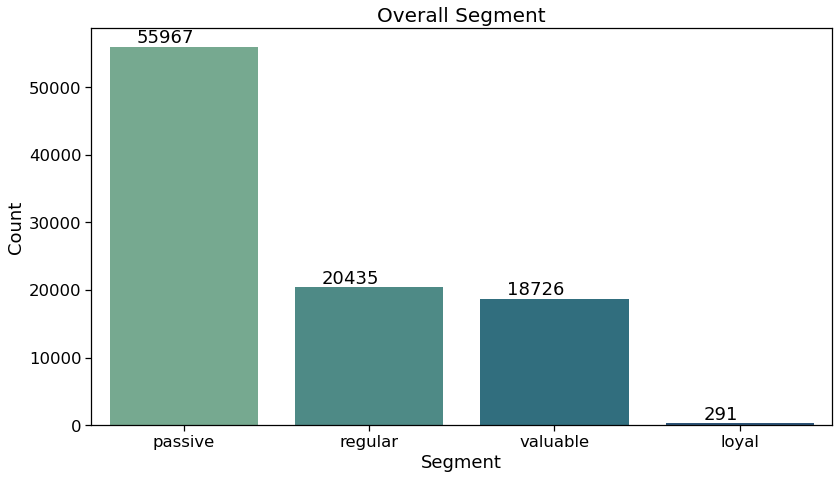

In [112]:
plt.figure(figsize=(12, 7))
overall_cat = overall['customer_segment'].value_counts()
pal = sns.color_palette('crest', len(overall_cat))
graph =sns.barplot(x=overall_cat.index, y=overall_cat.values, palette=pal) 
for p in graph.patches:
        graph.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()),
                    ha='center', va='bottom',
                    color= 'black')     
plt.title('Overall Segment', size=20)
plt.ylabel('Count')
plt.xlabel('Segment')
plt.tight_layout()
plt.show()

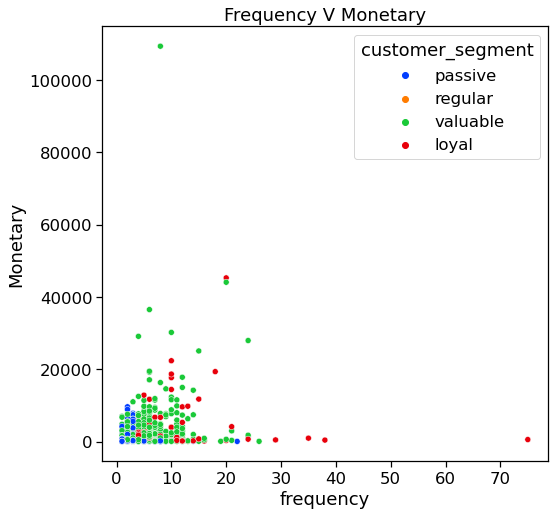

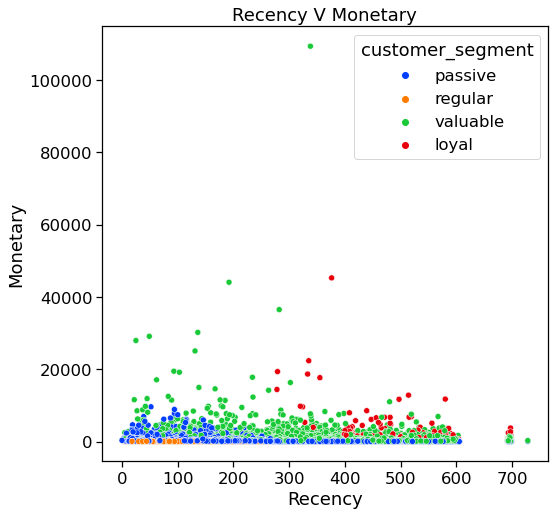

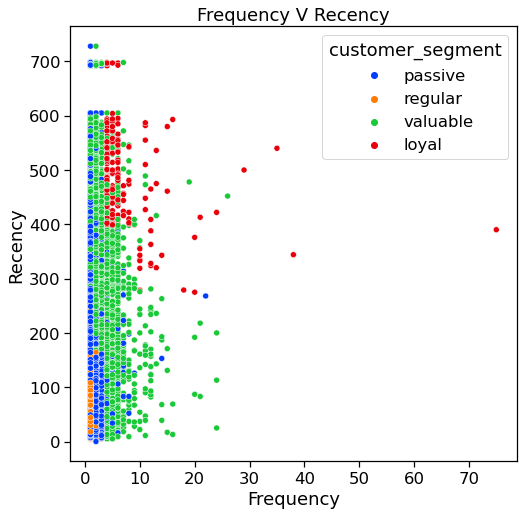

In [113]:
# Frequency V Monetary
plt.figure(figsize = (8, 8) )
sns.set_context(context = 'notebook', font_scale=1.5)
sns.scatterplot(
    x = 'frequency', 
    y = 'monetary', 
    hue = 'customer_segment',
    data = overall,
    palette='bright')
plt.title('Frequency V Monetary')
plt.ylabel('Monetary')
plt.xlabel('frequency')
plt.show()

# Monetary V Recency
plt.figure(figsize = (8, 8) )
sns.set_context(context = 'notebook', font_scale=1.5)
sns.scatterplot(
    x = 'recency', 
    y = 'monetary', 
    hue = 'customer_segment',
    data = overall,
    palette='bright')
plt.title('Recency V Monetary')
plt.ylabel('Monetary')
plt.xlabel('Recency')
plt.show()

# Frequency V Recency
plt.figure(figsize = (8, 8) )
sns.set_context(context = 'notebook', font_scale=1.5)
sns.scatterplot(
    x = 'frequency', 
    y = 'recency', 
    hue = 'customer_segment',
    data = overall,
    palette='bright')
plt.title('Frequency V Recency')
plt.ylabel('Recency')
plt.xlabel('Frequency')
plt.show()

## Jelaskan per cluster atau breakdown

## Using kuantitative Models KMeans(Sillhoutte)

**Using k-means, we can get 6 clusters, there are passive, regular, occasion, valuable, loyal, and best. Passive is when frequency, recency, and monetary values are the lowest. Regular is when transactions are high but still low in monetary and frequency. Occasion is when a transaction and it's value are increasing but still low in frequency. Valuable is when transaction and it's value are in the low-middle, but recency value is the increasing. Loyal is when monetary value is the second highest, frequency and monetary value is high. Best is frequency, monetary, and recency values are the highest.**

In [49]:
scaled_features = overall[['recency','frequency','monetary']].copy()

In [50]:
# Scaling our features
col_names = ['monetary', 'recency','frequency']
features = scaled_features[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

In [51]:
scaled_features[col_names] = features
scaled_features

,recency,frequency,monetary
0,-0.833414,-0.282446,-0.110526
1,-0.813826,-0.282446,-0.289269
2,1.948149,-0.282446,-0.197287
3,0.537779,-0.282446,-0.263667
4,0.322306,-0.282446,-0.024840
...,...,...,...
95414,1.360495,0.932534,6.111335
95415,0.152539,-0.282446,-0.199843
95416,2.150564,-0.282446,-0.156400
95417,-0.781178,-0.282446,-0.123319


In [52]:
silhouette_scores = []
number_of_cluster = range(2, 11)

for i in number_of_cluster:
  kmeans = KMeans(n_clusters=i, random_state=0)
  kmeans.fit(scaled_features)

  labels = kmeans.labels_
  silhouette_scores.append(silhouette_score(scaled_features, labels, metric = 'euclidean', random_state=0))

Text(0, 0.5, 'Silhouette score')

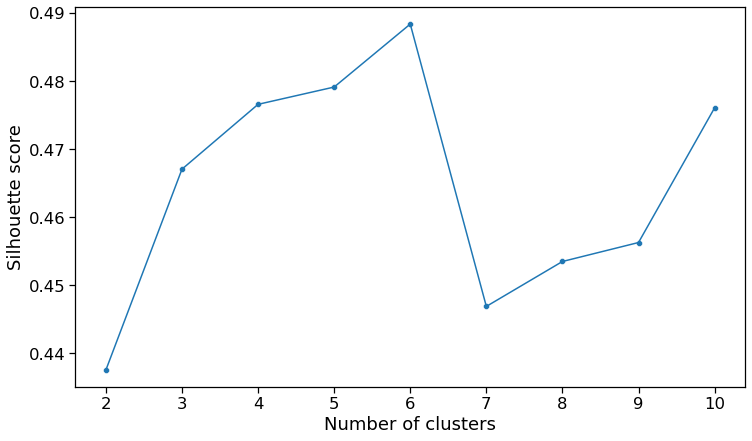

In [53]:
# Plotting the Sillhoutte Score
plt.figure(figsize=(12,7))

sns.lineplot(number_of_cluster, silhouette_scores)
sns.scatterplot(number_of_cluster, silhouette_scores)

plt.xticks(number_of_cluster)

plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')

In [54]:
kmeans = KMeans(n_clusters=6)
kmeans.fit(scaled_features)

KMeans(n_clusters=6)

In [55]:
scaled_features['k_means_clust'] = kmeans.labels_
scaled_features


,recency,frequency,monetary,k_means_clust
0,-0.833414,-0.282446,-0.110526,4
1,-0.813826,-0.282446,-0.289269,4
2,1.948149,-0.282446,-0.197287,0
3,0.537779,-0.282446,-0.263667,0
4,0.322306,-0.282446,-0.024840,0
...,...,...,...,...
95414,1.360495,0.932534,6.111335,1
95415,0.152539,-0.282446,-0.199843,4
95416,2.150564,-0.282446,-0.156400,0
95417,-0.781178,-0.282446,-0.123319,4


In [56]:
# Distributions Clusters
scaled_features['k_means_clust'].value_counts()

4    47967
0    35654
3    10816
1      953
2       28
5        1
Name: k_means_clust, dtype: int64

In [100]:
#assign customer segmentation based on overall score
ksegment_lst = scaled_features['k_means_clust']
ksegment_cluster = []

for i in ksegment_lst:
    if i == 4:
        cluster = 'passive'
        ksegment_cluster.append(cluster)
    elif i == 3:
        cluster = 'regular'
        ksegment_cluster.append(cluster)
    elif i == 0:
        cluster = 'occation'
        ksegment_cluster.append(cluster)
    elif i == 1:
        cluster = 'valuable'
        ksegment_cluster.append(cluster)
    elif i == 2:
        cluster = 'loyal'
        ksegment_cluster.append(cluster)
    else:
        cluster = 'best'
        ksegment_cluster.append(cluster)
        

In [101]:
scaled_features['k_means_segment'] = ksegment_cluster

In [102]:
scaled_features

,recency,frequency,monetary,k_means_clust,k_means_segment
0,-0.833414,-0.282446,-0.110526,4,passive
1,-0.813826,-0.282446,-0.289269,4,passive
2,1.948149,-0.282446,-0.197287,0,occation
3,0.537779,-0.282446,-0.263667,0,occation
4,0.322306,-0.282446,-0.024840,0,occation
...,...,...,...,...,...
95414,1.360495,0.932534,6.111335,1,valuable
95415,0.152539,-0.282446,-0.199843,4,passive
95416,2.150564,-0.282446,-0.156400,0,occation
95417,-0.781178,-0.282446,-0.123319,4,passive


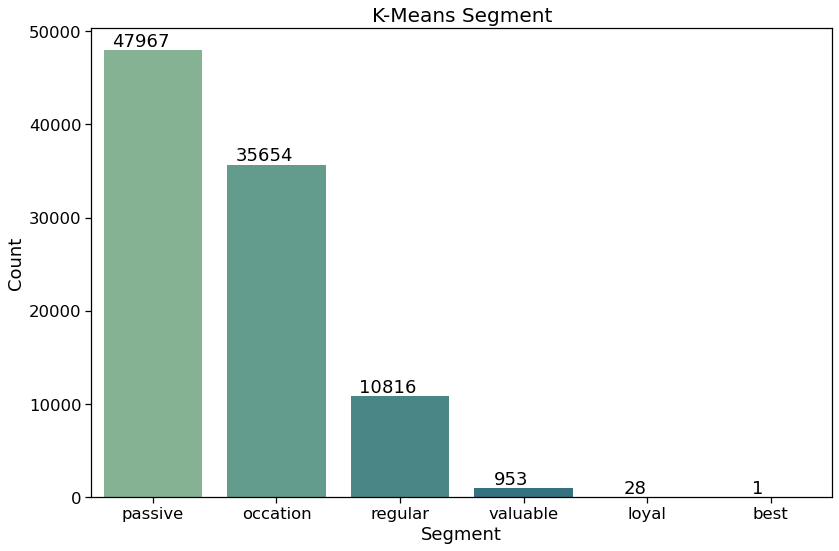

In [103]:
plt.figure(figsize=(12, 8))
df_kmeans_cat = scaled_features['k_means_segment'].value_counts()
pal = sns.color_palette('crest', len(df_kmeans_cat))
graph =sns.barplot(x=df_kmeans_cat.index, y=df_kmeans_cat.values, palette=pal) 
for p in graph.patches:
        graph.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()),
                    ha='center', va='bottom',
                    color= 'black')     
plt.title('K-Means Segment', size=20)
plt.ylabel('Count')
plt.xlabel('Segment')
plt.tight_layout()
plt.show()

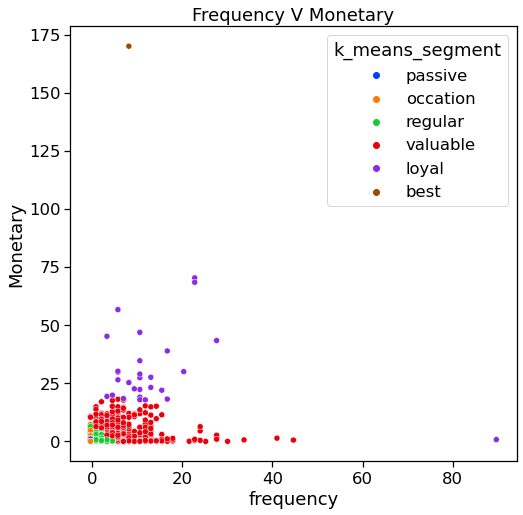

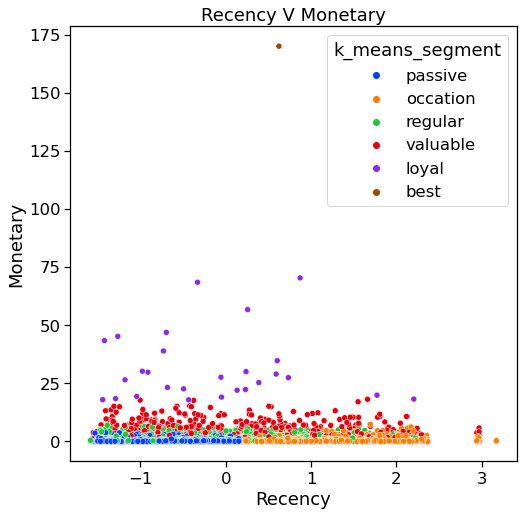

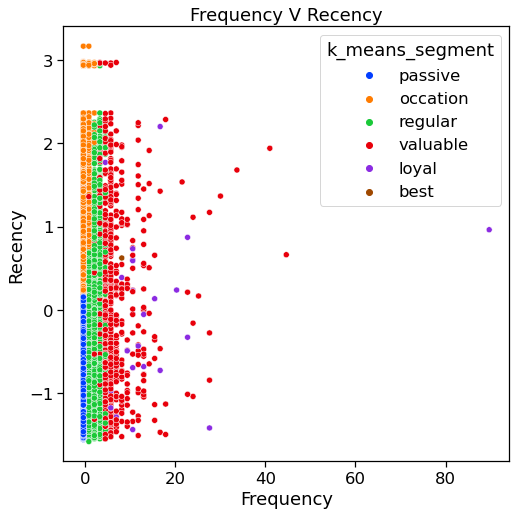

In [104]:
# Frequency V Monetary
plt.figure(figsize = (8, 8) )
sns.set_context(context = 'notebook', font_scale=1.5)
sns.scatterplot(
    x = 'frequency', 
    y = 'monetary', 
    hue = 'k_means_segment',
    data = scaled_features,
    palette='bright')
plt.title('Frequency V Monetary')
plt.ylabel('Monetary')
plt.xlabel('frequency')
plt.show()

# Monetary V Recency
plt.figure(figsize = (8, 8) )
sns.set_context(context = 'notebook', font_scale=1.5)
sns.scatterplot(
    x = 'recency', 
    y = 'monetary', 
    hue = 'k_means_segment',
    data = scaled_features,
    palette='bright')
plt.title('Recency V Monetary')
plt.ylabel('Monetary')
plt.xlabel('Recency')
plt.show()

# Frequency V Recency
plt.figure(figsize = (8, 8) )
sns.set_context(context = 'notebook', font_scale=1.5)
sns.scatterplot(
    x = 'frequency', 
    y = 'recency', 
    hue = 'k_means_segment',
    data = scaled_features,
    palette='bright')
plt.title('Frequency V Recency')
plt.ylabel('Recency')
plt.xlabel('Frequency')
plt.show()

## DBSCAN Clustering

**Using dbscan clustering, we can get 7 clusters, there are passive, regular, occasion, valuable, loyal, golden and best. Passive is when frequency, frequency, and monetary values are the lowest. Regular is when transaction value is increasing but still low in frequency and monetary value is low. Occasion is when frequency value is the third lowest, but transaction value is increasing even monetary is still low. Valuable is when values of monetary and transaction are in the middle of all values. Loyal is when monetary and frequency values are high, and transaction value is in the middle of all values. Golden is when frequency is in the middle but transaction and its value is high. Best is frequency, frequency, and monetary values are the highest.**

In [62]:
#for testing using sampling first
sample = resample(overall,n_samples=11843,random_state=13)
db_scaled_features = sample[['recency','frequency','monetary']].copy()

In [63]:
# Scaling our features
col_names = ['monetary', 'recency','frequency']
features = db_scaled_features[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

In [64]:
db_scaled_features[col_names] = features
db_scaled_features

,recency,frequency,monetary
47280,-0.118803,-0.271846,-0.108132
33634,-0.105672,-0.271846,-0.161570
87796,-0.204160,-0.271846,-0.171879
65689,0.708496,-0.271846,0.082419
25324,1.535796,-0.271846,-0.112425
...,...,...,...
43155,-0.388004,-0.271846,-0.181997
66630,-0.584980,-0.271846,1.666767
12982,-1.129947,4.400821,0.185730
71551,1.115580,-0.271846,-0.112321


In [65]:
for eps in [i/10 for i in range(4,9)]:
  for min_samples in range(4,9):
    print("\neps={}".format(eps))
    print("min_samples={}".format(min_samples))
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(db_scaled_features)
    silh = silhouette_score(db_scaled_features, labels)
    print("Clusters present: {}".format(np.unique(labels)))
    print("Cluster sizes: {}".format(np.bincount(labels + 1)))
    print("Silhouette Score: {}".format(silh))


eps=0.4
min_samples=4
Clusters present: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Cluster sizes: [  131 10081  1266   210    83    11    23     5     4     5     4     4
     6     6     4]
Silhouette Score: 0.27237389590431293

eps=0.4
min_samples=5
Clusters present: [-1  0  1  2  3  4  5  6  7  8]
Cluster sizes: [  158 10081  1262   209    83    11    23     5     6     5]
Silhouette Score: 0.27135362542082336

eps=0.4
min_samples=6
Clusters present: [-1  0  1  2  3  4  5  6]
Cluster sizes: [  169 10080  1262   209    83    11    23     6]
Silhouette Score: 0.2736227465849017

eps=0.4
min_samples=7
Clusters present: [-1  0  1  2  3  4  5]
Cluster sizes: [  178 10078  1262   209    83    10    23]
Silhouette Score: 0.27437342326970937

eps=0.4
min_samples=8
Clusters present: [-1  0  1  2  3  4  5]
Cluster sizes: [  183 10076  1262   208    81    10    23]
Silhouette Score: 0.2741839749688987

eps=0.5
min_samples=4
Clusters present: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 1

In [66]:
dbscan = DBSCAN(eps = 0.8, min_samples=4)
clusters = dbscan.fit_predict(db_scaled_features)

In [67]:
sample['dbscan_clusters'] = clusters

In [68]:
sample['dbscan_clusters'].value_counts()

 0    10106
 1     1274
 2      223
 3      108
-1       74
 5       30
 4       28
Name: dbscan_clusters, dtype: int64

In [69]:
#assign customer segmentation based on overall score
segment_lst = sample['dbscan_clusters']
segment_cluster = []

for i in segment_lst:
    if i == 0:
        cluster = 'passive'
        segment_cluster.append(cluster)
    elif i == 1:
        cluster = 'regular'
        segment_cluster.append(cluster)
    elif i == 2:
        cluster = 'occation'
        segment_cluster.append(cluster)
    elif i == 3:
        cluster = 'valuable'
        segment_cluster.append(cluster)
    elif i == -1:
        cluster = 'loyal'
        segment_cluster.append(cluster)
    elif i == 5:
        cluster = 'golden'
        segment_cluster.append(cluster)
    else:
        cluster = 'best'
        segment_cluster.append(cluster)
        

In [70]:
sample['dbscan_segment'] = segment_cluster

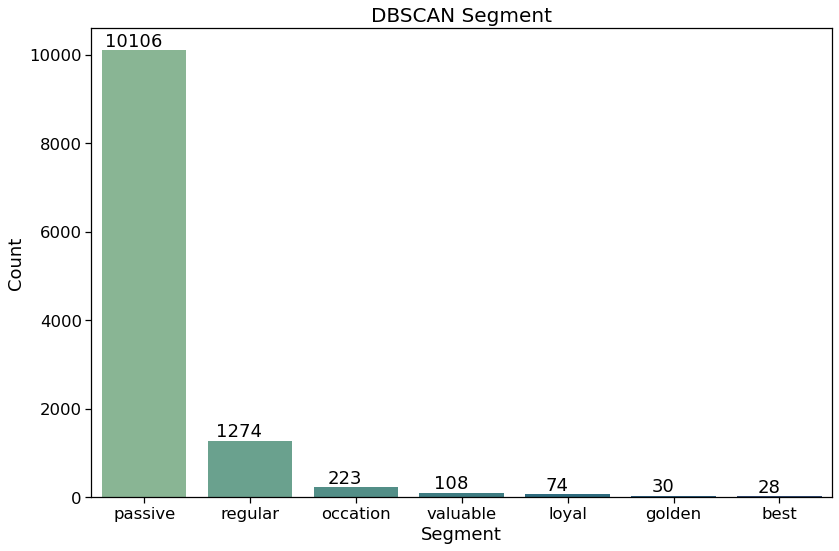

In [71]:
plt.figure(figsize=(12, 8))
df_algo_cat = sample['dbscan_segment'].value_counts()
pal = sns.color_palette('crest', len(df_algo_cat))
graph =sns.barplot(x=df_algo_cat.index, y=df_algo_cat.values, palette=pal) 
for p in graph.patches:
        graph.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()),
                    ha='center', va='bottom',
                    color= 'black')     
plt.title('DBSCAN Segment', size=20)
plt.ylabel('Count')
plt.xlabel('Segment')
plt.tight_layout()
plt.show()

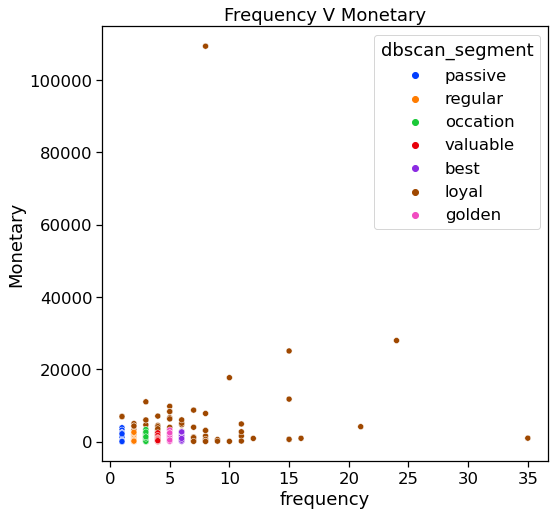

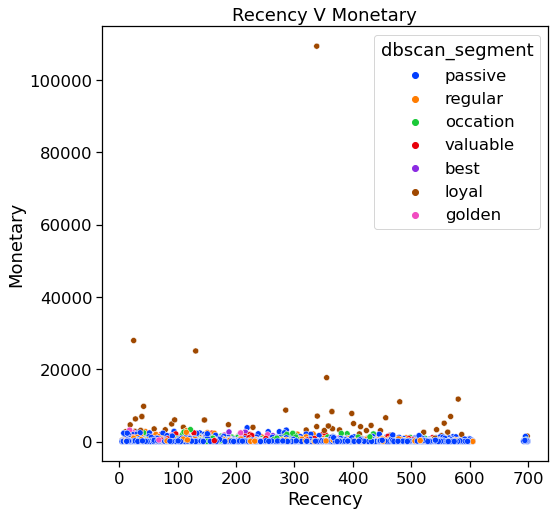

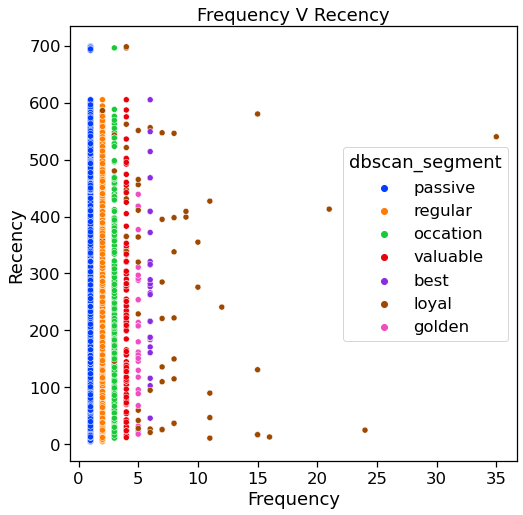

In [72]:
# Frequency V Monetary
plt.figure(figsize = (8, 8) )
sns.set_context(context = 'notebook', font_scale=1.5)
sns.scatterplot(
    x = 'frequency', 
    y = 'monetary', 
    hue = 'dbscan_segment',
    data = sample,
    palette='bright')
plt.title('Frequency V Monetary')
plt.ylabel('Monetary')
plt.xlabel('frequency')
plt.show()

# Monetary V Recency
plt.figure(figsize = (8, 8) )
sns.set_context(context = 'notebook', font_scale=1.5)
sns.scatterplot(
    x = 'recency', 
    y = 'monetary', 
    hue = 'dbscan_segment',
    data = sample,
    palette='bright')
plt.title('Recency V Monetary')
plt.ylabel('Monetary')
plt.xlabel('Recency')
plt.show()

# Frequency V Recency
plt.figure(figsize = (8, 8) )
sns.set_context(context = 'notebook', font_scale=1.5)
sns.scatterplot(
    x = 'frequency', 
    y = 'recency', 
    hue = 'dbscan_segment',
    data = sample,
    palette='bright')
plt.title('Frequency V Recency')
plt.ylabel('Recency')
plt.xlabel('Frequency')
plt.show()

## Using K-Means for Cluster Segmentation 

In [73]:
k_means = overall.drop(columns = ['customer_segment', 'overall_score'], axis = 1)

In [74]:
k_means['k_means_clust'] =  kmeans.labels_
k_means['k_means_segment'] = ksegment_cluster

In [75]:
pd.set_option('display.max_rows', 100)
k_means

,customer_unique_id,recency,recency_cluster,frequency,frequency_cluster,monetary,monetary_cluster,k_means_clust,k_means_segment
0,0000366f3b9a7992bf8c76cfdf3221e2,115,0,1,0,141.90,2,4,occation
1,0000b849f77a49e4a4ce2b2a4ca5be3f,118,0,1,0,27.19,0,4,occation
2,0000f46a3911fa3c0805444483337064,541,3,1,0,86.22,1,0,regular
3,0000f6ccb0745a6a4b88665a16c9f078,325,2,1,0,43.62,0,0,regular
4,0004aac84e0df4da2b147fca70cf8255,292,2,1,0,196.89,3,0,regular
...,...,...,...,...,...,...,...,...,...
95414,fffcf5a5ff07b0908bd4e2dbc735a684,451,3,2,1,4134.84,3,1,passive
95415,fffea47cd6d3cc0a88bd621562a9d061,266,1,1,0,84.58,1,4,occation
95416,ffff371b4d645b6ecea244b27531430a,572,3,1,0,112.46,2,0,regular
95417,ffff5962728ec6157033ef9805bacc48,123,0,1,0,133.69,2,4,occation


In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117601 entries, 0 to 118433
Data columns (total 25 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       117601 non-null  object        
 1   customer_id                    117601 non-null  object        
 2   order_status                   117601 non-null  object        
 3   order_purchase_timestamp       117601 non-null  object        
 4   order_item_id                  117601 non-null  float64       
 5   product_id                     117601 non-null  object        
 6   seller_id                      117601 non-null  object        
 7   price                          117601 non-null  float64       
 8   freight_value                  117601 non-null  float64       
 9   payment_sequential             117601 non-null  float64       
 10  payment_type                   117601 non-null  object        
 11  

In [77]:
df_k = df[['customer_unique_id', 'customer_state', 'seller_state', 'price', 'product_category_name_english', 'payment_type', 'payment_value', 'payment_installments', 'order_item_id']]

In [78]:
k_means = k_means.merge(df_k, on = 'customer_unique_id', how = 'left')

## Customer Segment Values

In [80]:
k_means[k_means['k_means_segment'] == 'passive']

,customer_unique_id,recency,recency_cluster,frequency,frequency_cluster,monetary,monetary_cluster,k_means_clust,k_means_segment,customer_state,seller_state,price,product_category_name_english,payment_type,payment_value,payment_installments,order_item_id
258,0096c18412349537abc45e350581cbbc,537,3,4,2,3080.96,3,1,passive,RS,SC,169.90,housewares,credit_card,770.24,8.0,1.0
259,0096c18412349537abc45e350581cbbc,537,3,4,2,3080.96,3,1,passive,RS,SC,169.90,housewares,credit_card,770.24,8.0,2.0
260,0096c18412349537abc45e350581cbbc,537,3,4,2,3080.96,3,1,passive,RS,SC,169.90,housewares,credit_card,770.24,8.0,3.0
261,0096c18412349537abc45e350581cbbc,537,3,4,2,3080.96,3,1,passive,RS,SC,169.90,housewares,credit_card,770.24,8.0,4.0
266,0097fca0db567f5ca79509b7b4fc1c2d,136,0,7,2,1593.41,3,1,passive,SP,SP,63.90,flowers,credit_card,227.63,10.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117371,ff7f36f6ba0f1126bb95b635322cf9d2,142,0,6,2,1735.92,3,1,passive,SP,RJ,29.99,health_beauty,credit_card,289.32,1.0,4.0
117372,ff7f36f6ba0f1126bb95b635322cf9d2,142,0,6,2,1735.92,3,1,passive,SP,RJ,29.99,health_beauty,credit_card,289.32,1.0,5.0
117373,ff7f36f6ba0f1126bb95b635322cf9d2,142,0,6,2,1735.92,3,1,passive,SP,RJ,29.99,health_beauty,credit_card,289.32,1.0,6.0
117595,fffcf5a5ff07b0908bd4e2dbc735a684,451,3,2,1,4134.84,3,1,passive,PE,SP,680.00,health_beauty,credit_card,2067.42,10.0,2.0


**Passive cluster is when frequency, recency, and monetary values are the lowest. In this cluster, customers are used to paying using credit card and boleto. They are likely to buy health beauty products, computer accessories, and houseware, including bed bath tables and sport leisure. Mostly, customers live in big states, like Sao Paulo and Rio de Janeiro and they buy products from near their state.**

In [81]:
k_means[k_means['k_means_segment'] == 'regular']

,customer_unique_id,recency,recency_cluster,frequency,frequency_cluster,monetary,monetary_cluster,k_means_clust,k_means_segment,customer_state,seller_state,price,product_category_name_english,payment_type,payment_value,payment_installments,order_item_id
2,0000f46a3911fa3c0805444483337064,541,3,1,0,86.22,1,0,regular,SC,SP,69.00,stationery,credit_card,86.22,8.0,1.0
3,0000f6ccb0745a6a4b88665a16c9f078,325,2,1,0,43.62,0,0,regular,PA,SP,25.99,telephony,credit_card,43.62,4.0,1.0
4,0004aac84e0df4da2b147fca70cf8255,292,2,1,0,196.89,3,0,regular,SP,SP,180.00,telephony,credit_card,196.89,6.0,1.0
9,0005e1862207bf6ccc02e4228effd9a0,547,3,1,0,150.12,2,0,regular,RJ,MG,135.00,fashion_bags_accessories,credit_card,150.12,3.0,1.0
11,0006fdc98a402fceb4eb0ee528f6a8d4,412,3,1,0,29.00,0,0,regular,ES,SP,13.90,bed_bath_table,credit_card,29.00,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117579,fff3a9369e4b7102fab406a334a678c3,387,2,1,0,102.74,1,0,regular,DF,MG,84.90,luggage_accessories,credit_card,102.74,2.0,1.0
117587,fff699c184bcc967d62fa2c6171765f7,366,2,1,0,55.00,0,0,regular,SP,MG,39.90,consoles_games,boleto,55.00,1.0,1.0
117591,fffa431dd3fcdefea4b1777d114144f2,307,2,1,0,81.20,1,0,regular,RJ,SP,64.99,cool_stuff,boleto,81.20,1.0,1.0
117598,ffff371b4d645b6ecea244b27531430a,572,3,1,0,112.46,2,0,regular,MT,MG,89.90,auto,credit_card,112.46,1.0,1.0


**Regular is when transactions are high but still low in monetary and frequency. In this cluster, customers are not only used to paying using credit card, boleto, but also voucher and debit card. They are likely to buy health beauty products, computer accessories, and houseware, including bed bath tables and sport leisure, which are more expensive . Mostly, customers live in big states, like Sao Paulo and Rio de Janeiro and they buy products from near their state but just a few of them live in small states, like Parana buy from big states and far from their residences.**

In [82]:
k_means[k_means['k_means_segment'] == 'occation']

,customer_unique_id,recency,recency_cluster,frequency,frequency_cluster,monetary,monetary_cluster,k_means_clust,k_means_segment,customer_state,seller_state,price,product_category_name_english,payment_type,payment_value,payment_installments,order_item_id
0,0000366f3b9a7992bf8c76cfdf3221e2,115,0,1,0,141.90,2,4,occation,SP,SP,129.90,bed_bath_table,credit_card,141.90,8.0,1.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,118,0,1,0,27.19,0,4,occation,SP,SP,18.90,health_beauty,credit_card,27.19,1.0,1.0
5,0004bd2a26a76fe21f786e4fbd80607f,150,0,1,0,166.98,2,4,occation,SP,SP,154.00,garden_tools,credit_card,166.98,8.0,1.0
6,00050ab1314c0e55a6ca13cf7181fecf,135,0,1,0,35.38,0,4,occation,SP,SP,27.99,telephony,boleto,35.38,1.0,1.0
10,0005ef4cd20d2893f0d9fbd94d3c0d97,174,1,1,0,129.76,2,4,occation,MA,RJ,104.90,sports_leisure,credit_card,129.76,4.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117592,fffb09418989a0dbff854a28163e47c6,259,1,1,0,73.16,1,4,occation,RS,SC,58.00,watches_gifts,boleto,73.16,1.0,1.0
117593,fffbf87b7a1a6fa8b03f081c5f51a201,249,1,1,0,167.32,2,4,occation,CE,SP,149.00,Missing,credit_card,167.32,2.0,1.0
117594,fffcc512b7dfecaffd80f13614af1d16,145,0,1,0,710.70,3,4,occation,RJ,SP,688.00,watches_gifts,credit_card,710.70,3.0,1.0
117597,fffea47cd6d3cc0a88bd621562a9d061,266,1,1,0,84.58,1,4,occation,BA,SP,64.89,baby,credit_card,84.58,1.0,1.0


**Occasion is when a transaction and it's value are increasing but still low in frequency. In this cluster, customer is not only used to pay using credit card, boleto, but also voucher and debit card. They are likely to buy health beauty products, computer accessories, and houseware, including bed bath tables and sport leisure. Mostly, customers live in big states, like Sao Paulo and Rio de Janeiro and they buy products from near their state but just a little of them live in small states, like Parana and buy from big states that are not far away from their residences.**

In [83]:
k_means[k_means['k_means_segment'] == 'valuable']

,customer_unique_id,recency,recency_cluster,frequency,frequency_cluster,monetary,monetary_cluster,k_means_clust,k_means_segment,customer_state,seller_state,price,product_category_name_english,payment_type,payment_value,payment_installments,order_item_id
4588,09e9991c50513a303a2da26619870d7f,235,1,10,3,12300.00,3,2,valuable,SP,SP,109.89,computers_accessories,credit_card,1230.00,1.0,1.0
4589,09e9991c50513a303a2da26619870d7f,235,1,10,3,12300.00,3,2,valuable,SP,SP,109.89,computers_accessories,credit_card,1230.00,1.0,2.0
4590,09e9991c50513a303a2da26619870d7f,235,1,10,3,12300.00,3,2,valuable,SP,SP,109.89,computers_accessories,credit_card,1230.00,1.0,3.0
4591,09e9991c50513a303a2da26619870d7f,235,1,10,3,12300.00,3,2,valuable,SP,SP,109.89,computers_accessories,credit_card,1230.00,1.0,4.0
4592,09e9991c50513a303a2da26619870d7f,235,1,10,3,12300.00,3,2,valuable,SP,SP,109.89,computers_accessories,credit_card,1230.00,1.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117582,fff5eb4918b2bf4b2da476788d42051c,62,0,6,2,17069.76,3,2,valuable,PB,SP,175.00,signaling_and_security,boleto,2844.96,1.0,2.0
117583,fff5eb4918b2bf4b2da476788d42051c,62,0,6,2,17069.76,3,2,valuable,PB,SP,175.00,signaling_and_security,boleto,2844.96,1.0,3.0
117584,fff5eb4918b2bf4b2da476788d42051c,62,0,6,2,17069.76,3,2,valuable,PB,SP,175.00,signaling_and_security,boleto,2844.96,1.0,4.0
117585,fff5eb4918b2bf4b2da476788d42051c,62,0,6,2,17069.76,3,2,valuable,PB,SP,175.00,signaling_and_security,boleto,2844.96,1.0,5.0


**Valuable is when transaction and it's value are in the low-middle, but recency value is the increasing. In this cluster, customer is likely to pay using credit card and voucher. They are more likely to buy housewares, including a bed bath table than health beauty products and computer accessories. Mostly, customers live in big states, like Sao Paulo and Rio de Janeiro and they buy products from near their state but just a little of them live in small states, like Rio Grande Sel and buy from small states that are not far away from their residences.**

In [87]:
k_means[k_means['k_means_segment'] == 'loyal'].sample(5)

,customer_unique_id,recency,recency_cluster,frequency,frequency_cluster,monetary,monetary_cluster,k_means_clust,k_means_segment,customer_state,seller_state,price,product_category_name_english,payment_type,payment_value,payment_installments,order_item_id
40810,58f5a0b391493cf37a8c32956f14d6d1,193,1,2,1,371.78,3,3,loyal,DF,SP,145.00,watches_gifts,boleto,160.76,1.0,1.0
94001,cc47f99364c6a2b50a87c1bbb3e4f0f8,150,0,4,2,915.01,3,3,loyal,RJ,SP,74.90,auto,boleto,94.39,1.0,1.0
6362,0ded1a5d4471ac84c9d5008b5455e0b7,53,0,2,1,217.00,3,3,loyal,MG,SP,35.90,baby,voucher,108.50,1.0,2.0
101703,dcf8ab9bc34d2f516f07ed071efdbe99,281,2,5,2,116.24,2,3,loyal,MG,MG,89.99,garden_tools,voucher,2.96,1.0,1.0
50773,6ebb1ed7033f7f9f97270661d5660b6f,163,0,3,1,776.55,3,3,loyal,RS,PR,79.90,furniture_decor,credit_card,258.85,10.0,2.0


**Loyal is when monetary value is the second highest, frequency and monetary value is high. In this cluster, customer is likely to pay using credit card, boleto, and voucher. They are more likely to buy computer accessories than housewares, including a bed bath table and do not like to buy health beauty products. Mostly, customers live in big states (São Paulo) and near the state, even in the small state, like Goias. big states like Sao Paulo and Rio de Janairo and they buy products from Sao Paulo.**

In [116]:
k_means[k_means['k_means_segment'] == 'best'].head(1)

,customer_unique_id,recency,recency_cluster,frequency,frequency_cluster,monetary,monetary_cluster,k_means_clust,k_means_segment,customer_state,seller_state,price,product_category_name_english,payment_type,payment_value,payment_installments,order_item_id
4674,0a0a92112bd4c708ca5fde585afaa872,338,2,8,2,109312.64,3,5,best,RJ,SP,1680.0,fixed_telephony,credit_card,13664.08,1.0,1.0


**Best is frequency, recency, and monetary values are the highest. In this cluster, customer only pay using credit cards. They only buy telephones. This customer lives in a big state (Rio de Janeiro) and only buys products from Sao Paulo.**

## Conclusion

Based on cluster segmentation using non-model framework, k-means clustering, and dbscan clustering, we will use segments from k-means clustering with 6 clusters that are passive, regular, occasion, valuable, loyal, and best. K-means can group more clearly of every cluster, with minimize similarity with other clusters. With this clear segmentation, Olist can analyze customers more accurately so more get a company profit. Clearly segmentation can be an important thing in relationship marketing, because can increase understanding of customer necessities.

Cons, using other methods, segmentation division is not good as k-means clustering. Using non modeling, the lowest cluster is still mixed with middle clusters and middle clusters are mixed with the highest cluster. This makes it hard to analyze every cluster. Positive thing about this segmentation is that clusters are only divided into 4 groups which makes it easy to understand every customer's necessities.

In the meantime, using dbscan clustering, there are seven clusters that are making it hard to understand every cluster even though this model more clearly groups every cluster than non modeling. But, the lowest cluster joined with the second highest cluster and the middle cluster in recency - monetary relation. The good things of this model are recency - frequency and frequency - monetary is clearly grouped every cluster.

While using k-means clustering, cluster is the most clear. Even though, in recency-monetary relation, some point of the middle cluster is in the low value like the lowest and the second lowest but it is still not a problem because it is just a few points of the middle cluster. Even this model is grouping more than non modeling clusters, but it is still lower than dbscan clustering.

## Recomendation

**For Passive Customers** :

1. Give awareness of all product. This is to make customers buy from other product categories. 
2. Give discount of paying using credit card and boleto. This should be used to product they are used to buy, that are health beauty product, computer accessories, and houseware, inclusing bed bath table and sport leisure
3. Give free freight values because distance between state is still in their state and near their state.

**For Regular Customers**:
1. Give a 2nd purchases promotion, this will boost customer to go buy new things, because mainly frequency of regular customer only 1.
2. Give a recomendation a new product from last category buying.
3. Introducing a benefit for a loyal customers

**For Occation Customers**:
1. Adding a customers point that can be traded for voucher. This will help customer retain and make more purchase.
2. Adding a minigame that can add customers points,so customers often visit the main page.

**For Valuable Customers**:

1. Give bonus while they are buying product from Olist. This can be give point to exchange with voucher. 
2. Give discount of freight values because they are distance between state is still in their state and their payment values are quite high.
3. Give discount while they are using credit card to product that usually bought.

**For Loyal Customers**:

1. Give bonus while they are using credit card and Boleto. This can be give point to exchange with voucher. 
2. Give voucher if customer buy with high payments. This voucher should be used to buy other products in Olist.
3. Give discount of freight values because they are distance between state is still in their state and their payment values are high.

**For Best Customers**:

1. Give reward for customers. The reward is give discount of high value products.
2. Give event in certain calendar event (like Black Friday). This even is full of discount product that they are usually bought. This event should be notify to this customer segment.

